# Retrieving TESS light curves

In this notebook, we'll check for existing time series data in the TESS database using the list of open cluster members we found previously. 

We'll check these light curves for flares and compare the activity of clusters of different ages, and stars of different temperature (hopefully you'll find enough data for the analysis).

If you are not so familiar with the topic, you can check [this presentation](https://www.slideshare.net/jradavenport/bu-2014-davenport) on stellar flares and space photometry. 

*TL;DR*: flares are a result of reconnecting magnetic field lines in stellar atmospheres:

<img src="https://image.slidesharecdn.com/bu-2014-davenport-140318013053-phpapp01/95/spots-and-flares-stellar-activity-with-kepler-james-r-a-davenport-2014-9-638.jpg"
     width=500px
     style="display:block; float: center; margin-right: auto;" />
     
These can be best observed in stellar coronae in X-ray, but the strongest flares heat the photosphere, too, and cause a so-called white-light flare, that can be seen in optical regime: they can be observed as sudden brightenings followed by an exponential decay. Their shape can be more complex, like a strong eruption followed by multiple further events (possibly induced by the first eruption's [shockwave](https://www.youtube.com/watch?v=uSr7ynvVn58)).

<table>
<tr>
<td>
<img src="https://image.slidesharecdn.com/bu-2014-davenport-140318013053-phpapp01/95/spots-and-flares-stellar-activity-with-kepler-james-r-a-davenport-2014-14-638.jpg?cb=1395106758"
     width=400px
     style="float: left; margin-right: auto;" />  
<td>            
<img src="https://image.slidesharecdn.com/bu-2014-davenport-140318013053-phpapp01/95/spots-and-flares-stellar-activity-with-kepler-james-r-a-davenport-2014-15-638.jpg?cb=1395106758"
     width=400px
     style="float: right; margin-right: auto;" />
</table>

    
Flares tend to be more frequent on later-type stars: a large fraction of M-dwarf show flares, but they are much more rare in G-stars, but those still produce even [superflares occasionally](https://www.nature.com/articles/nature11063)!
Since activity is strongly related to the strength of the magnetic field, fast-rotating, young stars are typically more active. Also a star needs a dynamo to maintain a magnetic field, so we don't expect flares on massive ($1.3M_{\odot}$) stars that have an inner structure different from the Sun and lack a tachocline. Low-mass M stars ($<0.3M_{\odot}$) don't have a tachocline either, as they are fully convective, but here there are different dynamo mechanisms that can still produce strong magnetic fields (with somewhat different properties, e.g. no activity cycles) and flares. 
    
----------


OK, let's see our actual targets! First, we'll load the member list from the previous notebook using `astropy`.

In [1]:
from astroquery.mast import Observations
from astropy.table import Table

In [2]:
members = Table.read('./members.ngc752.json', format="pandas.json")
members[0:3]

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
int64,str27,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,int64,int64,float64,int64,int64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str82,float64
1635721458409799680,Gaia DR2 319390952296062080,319390952296062080,1540657275,2015.5,26.1064454889,0.0213923824,37.1326444983,0.018929232100000002,2.2825926801,0.02376771,96.0375518799,9.883128519,0.043763654400000004,-10.886632297,0.0440990038,0.1169698015,0.3030690253,-0.2899731398,-0.044579155700000005,-0.2271885276,-0.1750548035,-0.3267517686,0.1901143938,0.29957219960000003,0.3380360603,150,0,150,0,-4.3682413101,82.1501159668,0.0,0.0,31,True,79.6809616089,1.5491454534,0.0069282114,0.0217759442,17,10,0.0587246716,0,17,False,150,61700.4821663218,54.5401016016,1131.2864990234,13.712644577,17,30161.9878589478,104.8446849842,287.6825561523,14.1527385712,17,45109.301905174,128.5650623923,350.8674926758,13.1262550354,1.2199465036000001,0,1.0264835358,0.4400939941,0.5863895416,--,--,0,--,--,--,NOT_AVAILABLE,134.5176348392,-24.544148099,38.1322820149,24.4753744975,100001.0,5083.1850585938,4973.0,5200.0,0.0860000029,0.0250000004,0.1836999953,0.0410000011,0.0120000001,0.0909999982,200111.0,0.9187432528,0.877928853,0.9599068165,0.5077228546,0.49407354000000003,0.5213721395,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+319390952296062080,--
1635721458409799680,Gaia DR2 342477226146028928,342477226146028928,348610924,2015.5,29.1661372351,0.023651653,37.2747672509,0.029579299000000003,2.2434082504,0.0336590835,66.6509017944,9.4537128806,0.0558171198,-11.2893362514,0.0728272901,0.3137170374,0.1418880075,-0.3031136096,-0.2349045575,-0.47671818730000004,-0.5282514095,-0.6357350349,0.4356325567,0.5990873575,0.6169531345,131,0,131,0,-4.0459661484,71.6090164185,0.0,0.0,31,True,113.7468414307,1.59453949

Using the [walkthrough](https://astroquery.readthedocs.io/en/latest/mast/mast.html) we'll search for our targets and identify which of them have available light curves.

In [3]:
import numpy as np
import sys
lcarr=[]
i=0
for target in members:
    sys.stdout.write('.')
    str(target['ra'])+' '+str(target['dec'])
    obs = Observations.query_criteria(filters=["TESS"],
                                coordinates=str(target['ra'])+' '+str(target['dec']),
                               radius=5./60/60,
                               dataproduct_type="timeseries")

    if obs.__len__() > 0:
        print("\n")
        print(str(target["source_id"])+": ")

        print(str( obs.__len__() )+" light curve(s) found ["+str(i)+"]")
        lcarr.append(i)
    i+=1

lcarr=np.array(lcarr)

.

........................................................

342773059198043648: 
1 light curve(s) found [56]
.................

342893803614055168: 
1 light curve(s) found [73]
................

342937195667536512: 
1 light curve(s) found [89]
.......

342899537393760512: 
1 light curve(s) found [96]
........................

342890127122193280: 
1 light curve(s) found [120]
.

342855251987671040: 
1 light curve(s) found [121]
.......

342934313745568768: 
1 light curve(s) found [128]
.......................

342869236401143808: 
1 light curve(s) found [151]
..............................................

343118619382072832: 
1 light curve(s) found [197]
...............................................................................

331052784938332800: 
1 light curve(s) found [276]
............

As an example we'll download one sample light curve:

In [4]:
target=members[121]
obs = Observations.query_criteria(filters=["TESS"],
                                coordinates=str(target['ra'])+' '+str(target['dec']),
                               radius=5./60/60,
                               dataproduct_type="timeseries")
obs
data_products = Observations.get_product_list(obs["obsid"])
manifest = Observations.download_products(
    data_products[ data_products["productSubGroupDescription"]=="LC" ]
)

INFO: Found cached file ./mastDownload/TESS/tess2019306063752-s0018-0000000067467015-0162-s/tess2019306063752-s0018-0000000067467015-0162-s_lc.fits with expected size 1785600. [astroquery.query]


Let's see the output and check if the file really exists:

In [5]:
manifest

Local Path,Status,Message,URL
str123,str8,object,object
./mastDownload/TESS/tess2019306063752-s0018-0000000067467015-0162-s/tess2019306063752-s0018-0000000067467015-0162-s_lc.fits,COMPLETE,None,None


In [6]:
!ls -R mastDownload/TESS/

mastDownload/TESS/:
tess2019306063752-s0018-0000000067467015-0162-s

mastDownload/TESS/tess2019306063752-s0018-0000000067467015-0162-s:
tess2019306063752-s0018-0000000067467015-0162-s_lc.fits


Let's open the `fits` file we just got using `astropy`

In [7]:
from astropy.io import fits
lc = fits.open(manifest[0]["Local Path"])

Let's see what we have here... It's an array:

In [8]:
lc

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x114f48f40>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x114d921f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x114f44e50>]

In [9]:
lc[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-04-16'         / file creation date.                            
TSTART  =    1790.661200336749 / observation start time in BTJD                 
TSTOP   =    1815.019040883843 / observation stop time in BTJD                  
DATE-OBS= '2019-11-03T03:50:

In [10]:
lc[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                17554 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

The actual light curve is in `lc[1]` and can be accessed like that:

In [11]:
lc[1].data

FITS_rec([(1790.65633909, 0.00526161, 405501, nan, nan, nan, nan, nan, nan, 168, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (1790.65772799, 0.00526161, 405502, nan, nan, nan, nan, nan, nan,  32, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (1790.65911688, 0.00526162, 405503, nan, nan, nan, nan, nan, nan,  32, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          ...,
          (1815.03223498, 0.00477888, 423052, nan, nan, nan, nan, nan, nan,  16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (1815.03362382, 0.00477884, 423053, nan, nan, nan, nan, nan, nan,  16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (1815.03501266, 0.00477879, 423054, nan, nan, nan, nan, nan, nan,  16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)],
         dtype=(numpy.record, [('TIME', '>f8'), ('TIMECORR', '>f4'), ('CADENCENO', '>i4'), ('SAP_FLUX', '>f4'), ('SAP_FLUX_ERR', '>f4'), ('SAP_BKG', '>f4'), ('SAP_BKG_ERR', '>f4'), ('PDCSAP_FL

The most important columns for us will be the `TIME`, `SAP_FLUX` (simple aperture photometry) and `QUALITY`. The `PDCSAP` (Pre-search Data Conditioning Simple Aperture Photometry) data is passed through some processing (usually focused for finding exoplanet signals), which usually improves the light curves, but sometimes is known to remove physical signals, too. The `QUALITY` flag indicates different issues with the points, here we'll use only those where no such issues are present.

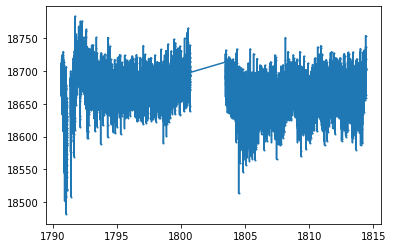

In [12]:
from matplotlib import pyplot as plt
mask = lc[1].data['QUALITY']==0
/plt.plot lc[1].data['TIME'][mask] lc[1].data['SAP_FLUX'][mask] "-o" ms=1
#plt.xlim(1792,1800)

Unfortunately this target doesn't seem to show anything interesting. What could be the reasons?

Check the other light curves and the other clusters, too - you can try smoothing the light curves to reveal weaker events, but keep in mind that flares have a time scale of minutes-hours, so smoothing can smear your signal!

If there are only a handful of events you find, they can be identified and analyzed manually, if there are many cases, the [FLATW'RM](https://github.com/vidakris/flatwrm) code can be helpful, just be sure to check the parameters, especially the detection (sigma) limit and the minimum number of flare points. If the rotation signal is undetectable, it's a good idea to input something on the timescale of a few days manually that's longer than the time scale of the flares.

In the case if all the open cluster members seem to be boring, you can try to select either other clusters, or compare nearby field stars with different temperatures (F-G-K-M types) - but in this case, we won't have much information on their age.